In [1]:
import pyspark
from pyspark.sql import *
import pandas as pd
import matplotlib as plt
import altair as alt
alt.renderers.enable('notebook')
import sys
sys.path.append("..")
from helper import load_countries, join_countries

/home/karna/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/karna/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
DATA_PATH = "../../data/"

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
# Read the parquet computed on the cluster and renamne columns
tones_df = spark.read.parquet(DATA_PATH + "tone_mentions_5themes_europe.parquet")
tones = tones_df.toPandas()
tones.columns = ["DAY","MONTH","YEAR","tone_mean","STATE"]
tones.head()

,DAY,MONTH,YEAR,tone_mean,STATE
0,28.0,8.0,2017.0,-1.025211,SW
1,22.0,3.0,2016.0,-2.242470,RS
2,25.0,4.0,2016.0,-1.207046,FR
3,24.0,11.0,2015.0,-1.824279,FR
4,10.0,10.0,2015.0,-2.729527,CH


In [5]:
# Read the number of mentions computed by state and day on the cluster
counts = pd.read_csv(DATA_PATH + "mentions_counts_by_state_and_day_filtered_5themes.csv")
counts.head()

,STATE,YEAR,MONTH,DAY,GLOBAL_COUNT,ENV_COUNT
0,NaN,2015.0,10.0,22.0,21861,NaN
1,NaN,2016.0,2.0,16.0,306734,NaN
2,NaN,2016.0,4.0,27.0,324925,NaN
3,NaN,2017.0,1.0,2.0,161525,NaN
4,NaN,2017.0,1.0,8.0,173637,NaN


In [6]:
countries = load_countries(DATA_PATH)

From this point, we have loaded all the files needed to compute our visualization. Now we should clean them and join each of them.

In [7]:
# We are interested only on European states
states = countries[countries.Region=="Europe"].FIPS.values

In [8]:
counts = join_countries(counts,countries,states)
counts.head()

,GLOBAL_COUNT,ENV_COUNT,Country,DATE
7020,568,27.0,Albania,2015-10-23
7021,246,18.0,Albania,2016-01-28
7022,337,55.0,Albania,2016-02-18
7026,2191,4.0,Albania,2016-06-19
7027,167,58.0,Albania,2015-04-09


In [9]:
tones = join_countries(tones,countries,states)
tones.head()

,tone_mean,Country,DATE
0,-1.025211,Sweden,2017-08-28
1,-3.231191,Sweden,2015-12-11
2,-3.629540,Sweden,2016-03-20
3,-3.296977,Sweden,2016-05-05
4,-1.461866,Sweden,2015-09-20


We have joined the count (count of mentions) and the tone tables with the table of countries (to get the real name of the country).

In [10]:
tones.describe()

,tone_mean
count,35392.000000
mean,-1.543688
std,1.844172
min,-28.029344
25%,-2.473540
50%,-1.792925
75%,-0.556229
max,10.190022


In [11]:
tones['tone_mean'].plot.hist()

As we are going to compute the mean tone over each country for each date, we need to clean out the tone table by removing outliers. To this purpose we remove, the 1% and the 99% quartiles

99% quantile: 3.48
1% quantile: -6.23


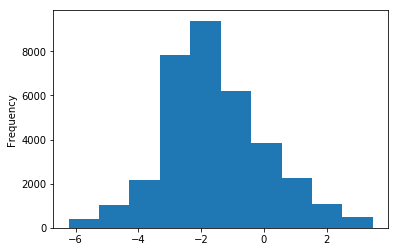

In [12]:
# We remove the 1% and 99 % quantile corresponding to outliers
q_plus = tones['tone_mean'].quantile(0.99)
q_minus = tones['tone_mean'].quantile(0.01)
print("99% quantile: {0:0.2f}" .format(q_plus))
print("1% quantile: {0:0.2f}" .format(q_minus))
tones = tones[(tones['tone_mean']>q_minus) & (tones['tone_mean']<q_plus)]
tones['tone_mean'].plot.hist()

In [13]:
#We group by weeks and country and compute the mean
tones = tones.groupby([(pd.Grouper(key='DATE',freq='W')),"Country"]).mean()
tones = tones.reset_index()
tones.head()

,DATE,Country,tone_mean
0,2015-02-22,Albania,-1.770555
1,2015-02-22,Austria,-0.590620
2,2015-02-22,Belarus,-2.197452
3,2015-02-22,Belgium,-1.900615
4,2015-02-22,Bosnia and Herzegovina,-3.384204


In [14]:
#We group by weeks and country and compute the ratio of mentions
counts = counts.groupby([(pd.Grouper(key='DATE',freq='W')),"Country"]).sum()
counts = counts.reset_index()
counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
counts.drop(columns=['GLOBAL_COUNT','ENV_COUNT'],inplace=True)
counts.head()

,DATE,Country,Ratio
0,2015-02-22,Albania,0.172113
1,2015-02-22,Austria,0.017400
2,2015-02-22,Belarus,0.044217
3,2015-02-22,Belgium,0.018466
4,2015-02-22,Bosnia and Herzegovina,0.103198


In [15]:
counts.describe()

,Ratio
count,5969.000000
mean,0.051834
std,0.075844
min,0.000484
25%,0.018224
50%,0.031170
75%,0.055556
max,1.000000


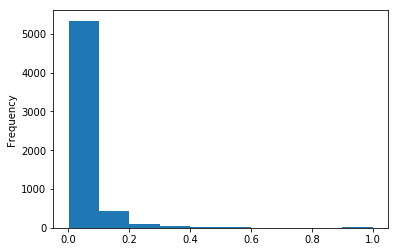

In [16]:
counts['Ratio'].plot.hist()

As we are going to plot the ratio of mention, we remove outliers that will distort the visualization, corresponding to the 1% and the 99% quartiles

98% quantile : 0.16
1% quantile : 0.00


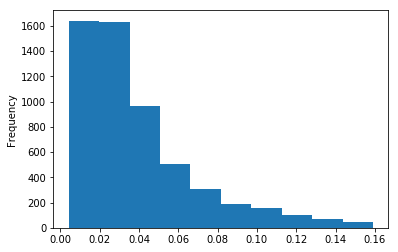

In [17]:
q_plus = counts['Ratio'].quantile(0.95)
q_minus = counts['Ratio'].quantile(0.01)
print("98% quantile : {0:0.2f}" .format(q_plus))
print("1% quantile : {0:0.2f}" .format(q_minus))
counts = counts[(counts['Ratio']>q_minus) & (counts['Ratio']<q_plus)]
counts['Ratio'].plot.hist()

We group by date and country computing the mean for the tone and the ratio of ecological mentions for the counts table.

In [18]:
count_tone = counts.merge(tones, on= ['DATE','Country'])
count_tone.head()

,DATE,Country,Ratio,tone_mean
0,2015-02-22,Austria,0.017400,-0.590620
1,2015-02-22,Belarus,0.044217,-2.197452
2,2015-02-22,Belgium,0.018466,-1.900615
3,2015-02-22,Bosnia and Herzegovina,0.103198,-3.384204
4,2015-02-22,Bulgaria,0.040196,-2.078712


count_tone.describe()

"count_tone" table is the final table that we are going to use for the visualization. We have the average tone and the ratio of ecological mentions for each week for each european country.

In [19]:
# We seperate the table for each year
def sep_year(table):
    return table[table['DATE'] < '2016-01-01'],\
    table[(table['DATE'] < '2017-01-01') & (table['DATE'] >= '2016-01-01')],\
    table[(table['DATE'] < '2018-01-01') & (table['DATE'] >= '2017-01-01')]

The visualization will be too small if we plot all the years together, so we plot a visualization for ech year.

In [20]:
counts_2015,counts_2016,counts_2017 = sep_year(count_tone)

We need to have the same color scale and the same ratio scale.

In [21]:
min_years_color = round(min(min(counts_2015.tone_mean),min(counts_2016.tone_mean),min(counts_2017.tone_mean)))
print("Min tone_mean:", min_years_color)
max_years_color = round(max(max(counts_2015.tone_mean),max(counts_2016.tone_mean),max(counts_2017.tone_mean)))
print("Max tone_mean:", max_years_color)
min_years_ratio = min(min(counts_2015.Ratio),min(counts_2016.Ratio),min(counts_2017.Ratio))
print("Min ratio:", min_years_ratio)
max_years_ratio = max(max(counts_2015.Ratio),max(counts_2016.Ratio),max(counts_2017.Ratio))
print("Max ratio:", max_years_ratio)

Min tone_mean: -5
Max tone_mean: 3
Min ratio: 0.004263093788063338
Max ratio: 0.15905511811023623


In [22]:
# This function compute the visualization a circle scatter plot
def circle_scatter_plot(table,year):
    x_title = "Date in %d (weekly divided)" % (year)
    
    palette = alt.Scale(domain=(min_years_color,max_years_color),range=['red','white','green'])
    size_ratio = alt.Scale(domain=(min_years_ratio,max_years_ratio))
    
    plot = alt.Chart(table).mark_circle(
        opacity=0.8,
        stroke='black',
        strokeWidth=1
    ).encode(
        alt.X('DATE:T', axis=alt.Axis(labelAngle=0, title=x_title)),
        alt.Y('Country:N'),
        alt.Size('Ratio:Q',
            scale=size_ratio,
            legend=alt.Legend(title='Ratio of mentions')
        ),
        alt.Color('tone_mean:Q', scale=palette,legend=alt.Legend(title='Mean Tone'))
    ).properties(
        width=500,
        height=800
    ).properties(
    title='Time evolution of the ratio of ecological mentions and the average tone by European country')
    
    return plot


We represent the metric ratio by circles of different size and the metric tone by the color of the circles.
We plot a separate visualization for each year as there will be too much information if we plot all the years on the same plot.

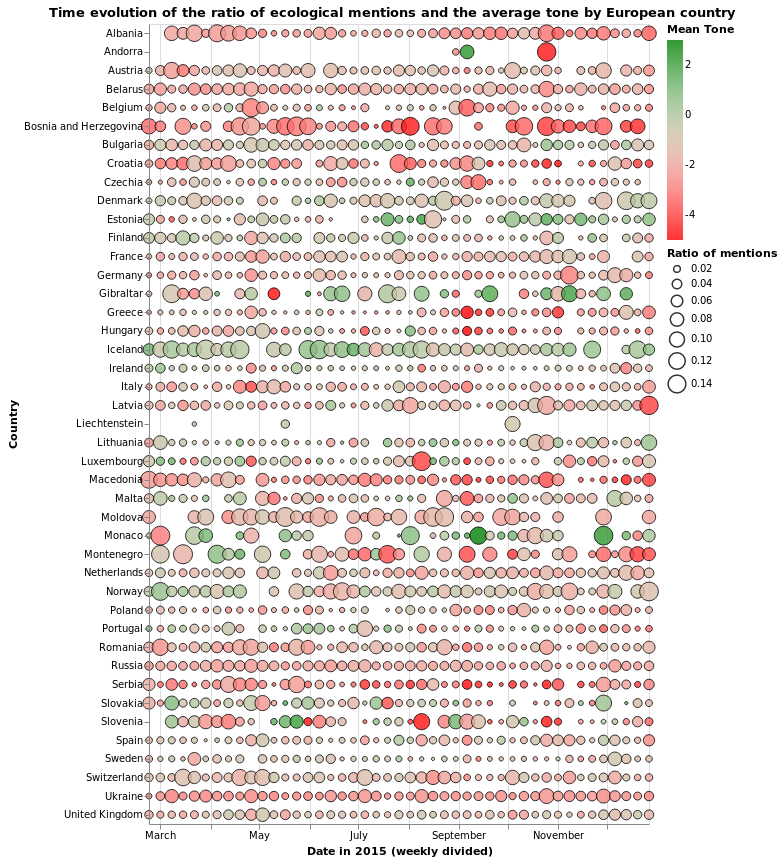

In [23]:
circle_scatter_plot(counts_2015,2015)

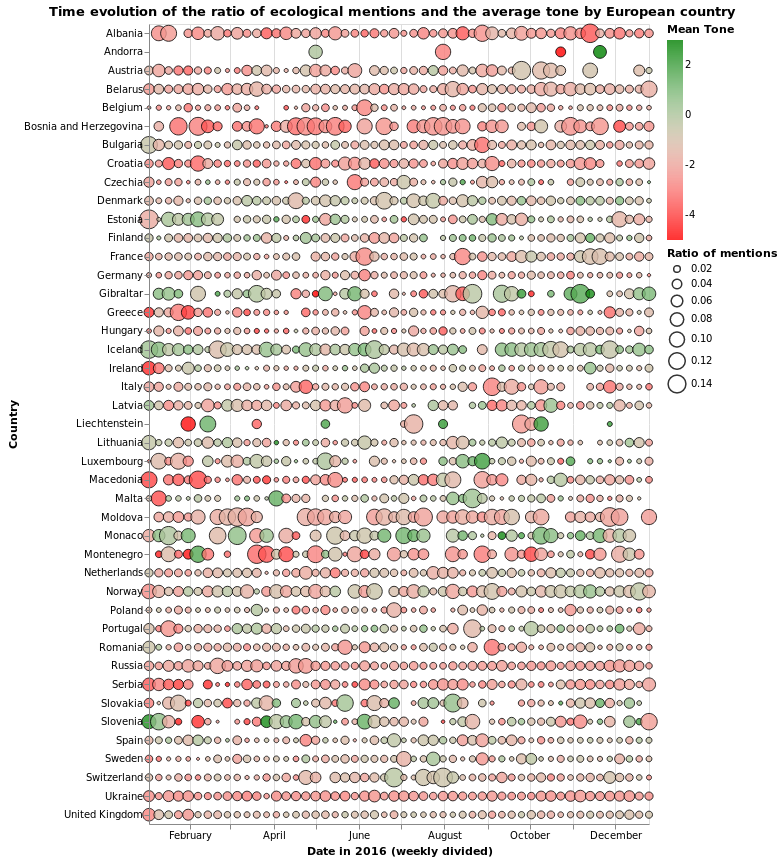

In [24]:
circle_scatter_plot(counts_2016,2016)

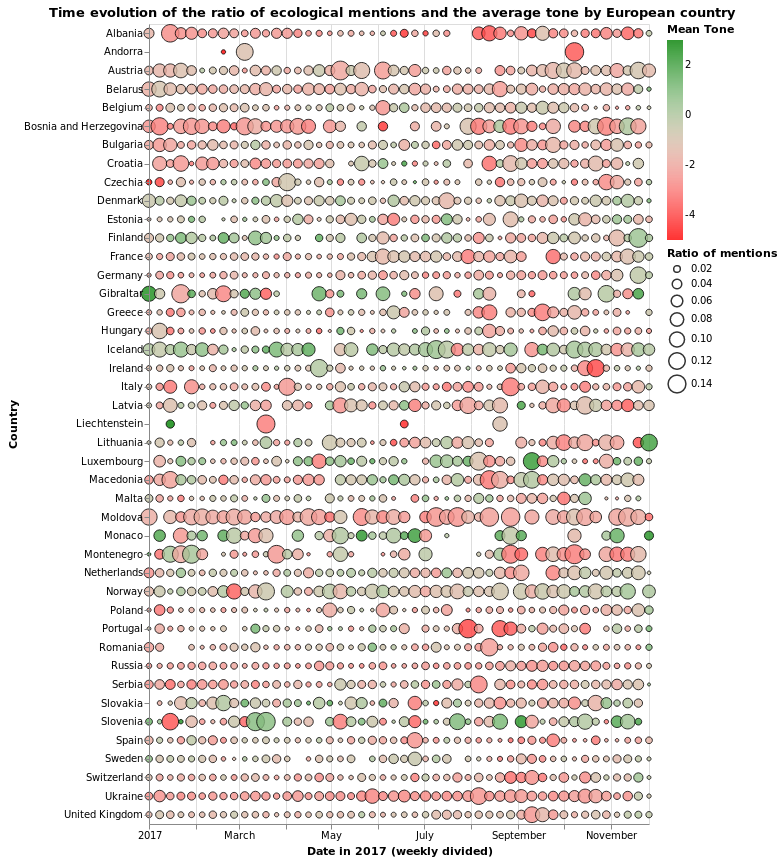

In [25]:
circle_scatter_plot(counts_2017,2017)